**Central Question:** Which combination of client demographics, prior-campaign outcomes, and phone-contact attributes most reliably signals that a customer will subscribe to a term-deposit after a direct-marketing call?

**Environment Setup**

In [23]:
# Core data libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For fetching the Bank Marketing data
from sklearn.datasets import fetch_openml

**Set Up & Data Load**

In [24]:
# import the data set
data = fetch_openml(data_id = 1461).frame

In [25]:
# rename columns
rename_map = {
    'V1': 'age',
    'V2': 'job',
    'V3': 'marital',
    'V4': 'education',
    'V5': 'default',
    'V6': 'balance',
    'V7': 'housing',
    'V8': 'loan',
    'V9': 'contact',
    'V10': 'day',
    'V11': 'month',
    'V12': 'duration',
    'V13': 'campaign',
    'V14': 'pdays',
    'V15': 'previous',
    'V16': 'poutcome',
    'Class': 'y'
}

data.rename(columns=rename_map, inplace=True)

In [26]:
data.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,1
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,1


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        45211 non-null  int64   
 1   job        45211 non-null  category
 2   marital    45211 non-null  category
 3   education  45211 non-null  category
 4   default    45211 non-null  category
 5   balance    45211 non-null  int64   
 6   housing    45211 non-null  category
 7   loan       45211 non-null  category
 8   contact    45211 non-null  category
 9   day        45211 non-null  int64   
 10  month      45211 non-null  category
 11  duration   45211 non-null  int64   
 12  campaign   45211 non-null  int64   
 13  pdays      45211 non-null  int64   
 14  previous   45211 non-null  int64   
 15  poutcome   45211 non-null  category
 16  y          45211 non-null  category
dtypes: category(10), int64(7)
memory usage: 2.8 MB


In [28]:
# Automatically grab all categorical columns
cat_cols = data.select_dtypes(include='category').columns.tolist()

for col in cat_cols:
    # Header with the column name
    print(f"\n=== Column: {col} ===")

    # Get the raw value‐counts
    counts = data[col].value_counts(dropna=False)

    # Remove the index name (which was the column name) and the Series name
    counts.index.name = None
    counts.name = None

    print(counts)
    print("-" * 40)


=== Column: job ===
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
dtype: int64
----------------------------------------

=== Column: marital ===
married     27214
single      12790
divorced     5207
dtype: int64
----------------------------------------

=== Column: education ===
secondary    23202
tertiary     13301
primary       6851
unknown       1857
dtype: int64
----------------------------------------

=== Column: default ===
no     44396
yes      815
dtype: int64
----------------------------------------

=== Column: housing ===
yes    25130
no     20081
dtype: int64
----------------------------------------

=== Column: loan ===
no     37967
yes     7244
dtype: int64
----------------------------------------

=== Column: contact ===
cellular     29285
unknown      13

**Data Cleaning**

In [29]:
# Define columns to clean
cols_to_clean = [col for col in cat_cols if col != 'poutcome']

# ‘cols_to_clean’ contains all categorical columns except 'poutcome'
for col in cols_to_clean:
    # Replace 'unknown' with real NaN, then convert back to a categorical dtype
    data[col] = data[col].replace('unknown', np.nan).astype('category')

# Verify how many NaNs were introduced
data[cols_to_clean].isna().sum()

<ipython-input-29-a94296c6c564>:7: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  data[col] = data[col].replace('unknown', np.nan).astype('category')


,0
job,288
marital,0
education,1857
default,0
housing,0
loan,0
contact,13020
month,0
y,0


In [30]:
# Remove rows missing 'job' or 'education'
data = data.dropna(subset=['job', 'education'])

# Drop 'contact' column
data = data.drop(columns=['contact'])

# Verify that 'job' and 'education' have no missing values
print(data[['job', 'education']].isna().sum())

job          0
education    0
dtype: int64


In [31]:
# Drop duplicate records
data.drop_duplicates(inplace=True)

# Map yes/no flags to 0/1
for col in ['default', 'housing', 'loan']:
    data[col] = data[col].map({'yes': 1, 'no': 0})

# Convert the target y to numeric 0/1
data['y'] = data['y'].astype('category').cat.codes

In [32]:
# Numeric columns
num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Categorical columns (all categories except 'y')
cat_cols = [c for c in data.select_dtypes(include='category').columns if c != 'y']

# Show numeric stats (count, mean, std, quartiles)
display(data[num_cols].describe().T)

# Show categorical stats (count, unique, top, freq)
display(data[cat_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
age,43193.0,40.764082,10.512640,18.0,33.0,39.0,48.0,95.0
balance,43193.0,1354.027342,3042.103625,-8019.0,71.0,442.0,1412.0,102127.0
day,43193.0,15.809414,8.305970,1.0,8.0,16.0,21.0,31.0
duration,43193.0,258.323409,258.162006,0.0,103.0,180.0,318.0,4918.0
campaign,43193.0,2.758178,3.063987,1.0,1.0,2.0,3.0,58.0
pdays,43193.0,40.404070,100.420624,-1.0,-1.0,-1.0,-1.0,871.0
previous,43193.0,0.584863,2.332672,0.0,0.0,0.0,0.0,275.0


,count,unique,top,freq
job,43193,11,blue-collar,9278
marital,43193,3,married,25946
education,43193,3,secondary,23131
default,43193,2,0,42411
housing,43193,2,1,24292
loan,43193,2,0,36086
month,43193,12,may,13192
poutcome,43193,4,unknown,35286


**Correlation**

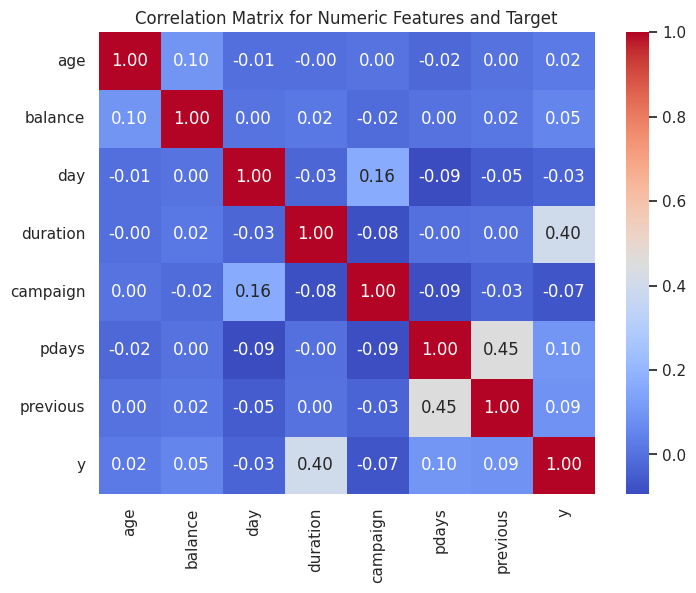

Absolute correlations with target'y':
y           1.000000
duration    0.397393
pdays       0.101446
previous    0.091764
campaign    0.072465
balance     0.051386
day         0.030247
age         0.024760
Name: y, dtype: float64


In [33]:
# compute correlation matrix for numeric features and the target
corr = data[num_cols + ['y']].corr()

# plot a heatmap of those correlations
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix for Numeric Features and Target")
plt.show()

# display absolute correlation values with the target 'y'
print("Absolute correlations with target'y':")
print(corr['y'].abs().sort_values(ascending=False))

**Key Visuals**

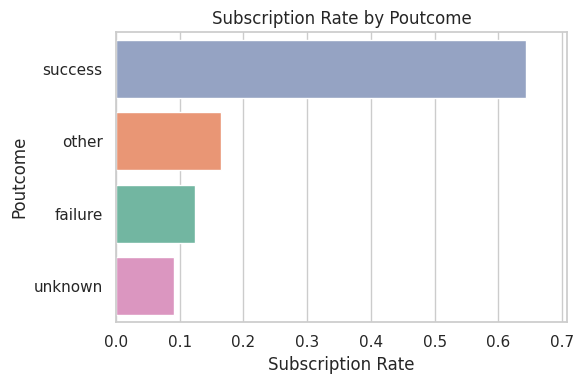

<ipython-input-34-8077118906f4>:23: UserWarning: 
The palette list has fewer values (8) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


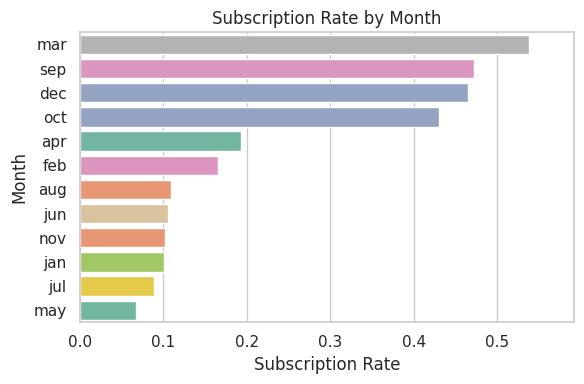

<ipython-input-34-8077118906f4>:23: UserWarning: 
The palette list has fewer values (8) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


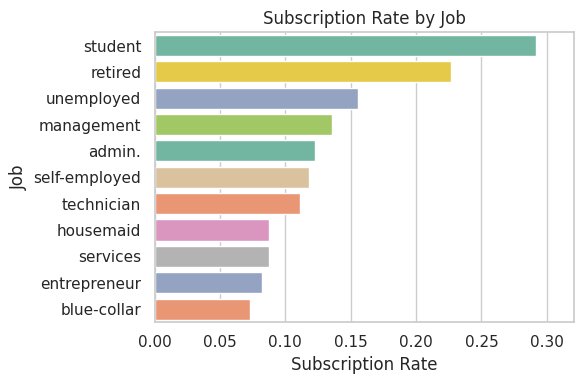

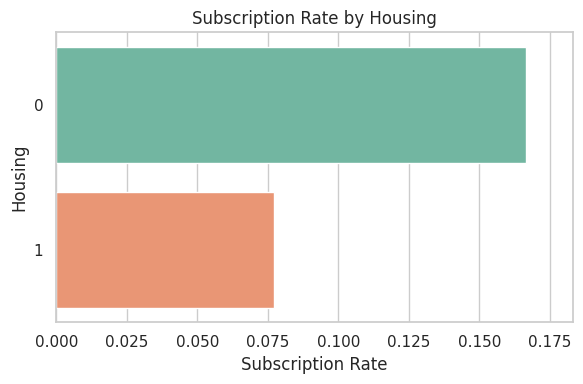

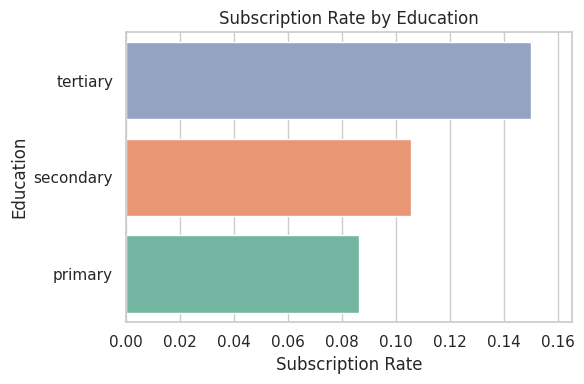

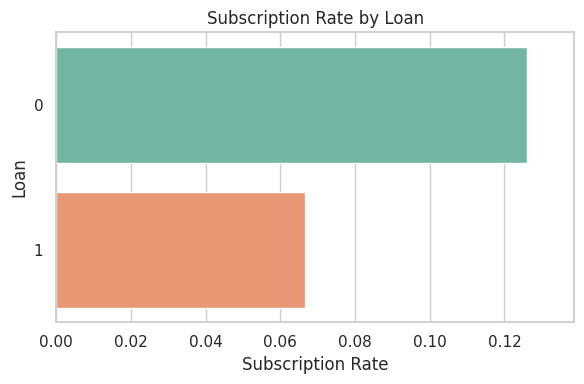

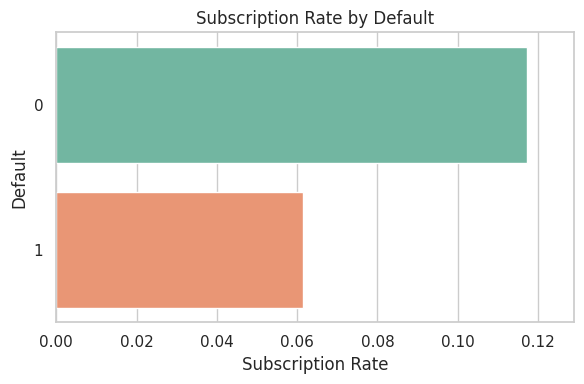

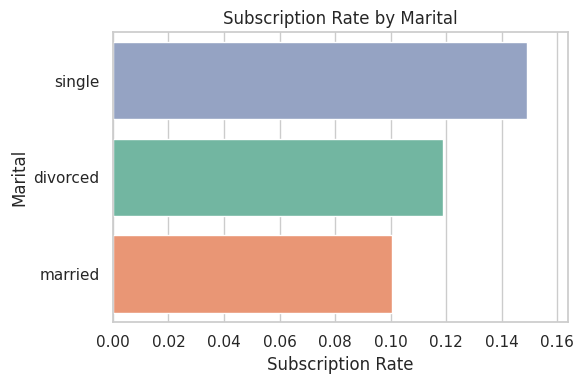

In [34]:
# list categorical predictors (excluding 'y')
cat_cols = [c for c in data.select_dtypes('category').columns if c != 'y']

# rank features by subscription‐rate spread
spreads = {
    col: data.groupby(col, observed=True)['y'].mean().max() - data.groupby(col, observed=True)['y'].mean().min()
    for col in cat_cols
}
sorted_feats = sorted(spreads, key=lambda c: spreads[c], reverse=True)

palette = sns.color_palette("Set2")

for col in sorted_feats:
    # compute and sort subscription rates descending
    rates = (
        data.groupby(col, observed=True)['y']
            .mean()
            .sort_values(ascending=False)
            .reset_index(name='rate')
    )

    plt.figure(figsize=(6, 4))
    sns.barplot(
        data=rates,
        x='rate',
        y=col,
        order=rates[col].tolist(),
        palette=palette[:len(rates)],
        dodge=False,
        hue=col,
        legend=False
    )
    plt.title(f'Subscription Rate by {col.capitalize()}')
    plt.xlabel('Subscription Rate')
    plt.ylabel(col.capitalize())
    plt.xlim(0, rates['rate'].max() * 1.1)
    plt.tight_layout()
    plt.show()


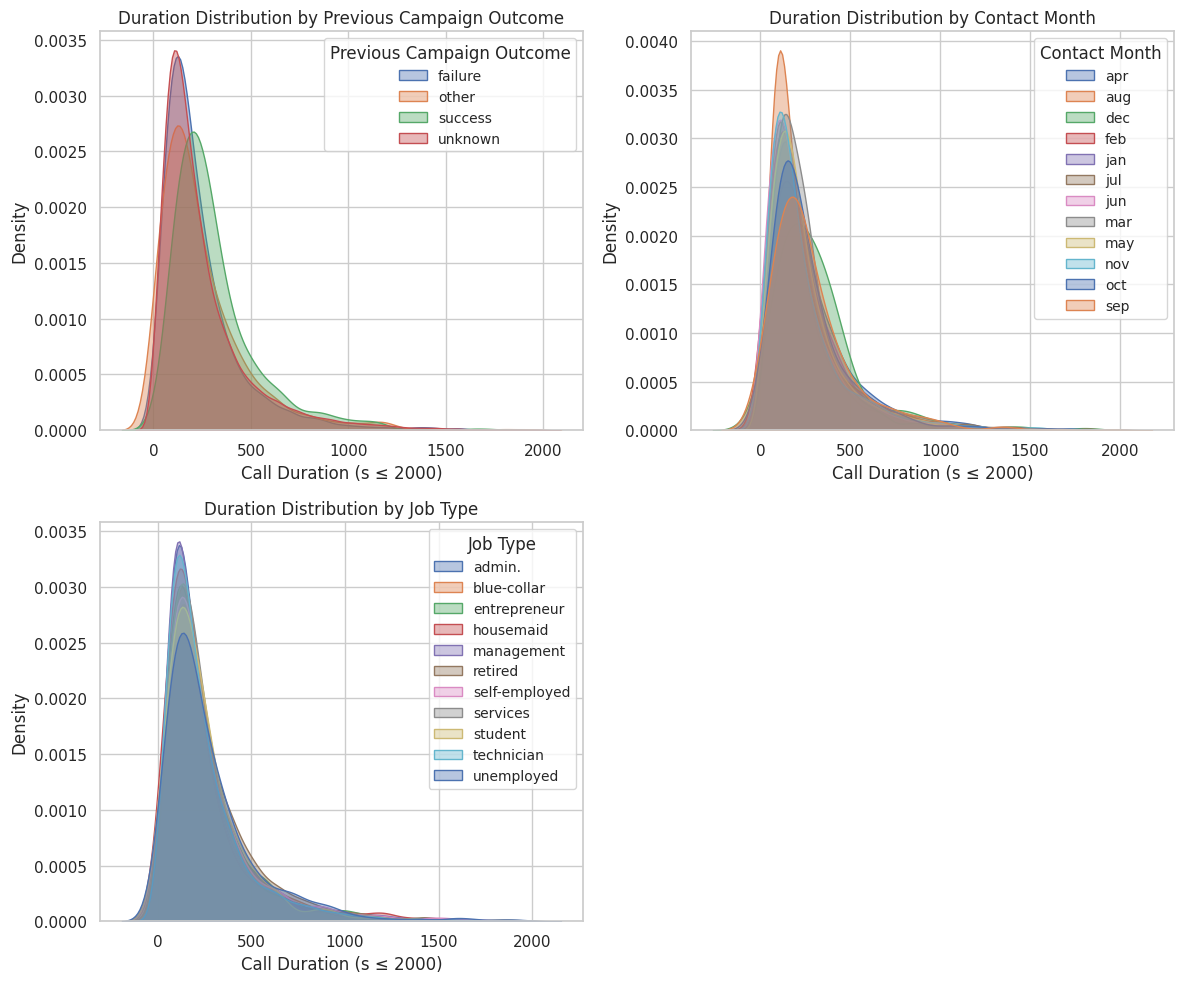

In [35]:
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 10)

# Filter out durations above 2000 seconds
filtered = data[data['duration'] <= 2000]

# Categorical features to plot
plot_args = [
    ('poutcome', 'Previous Campaign Outcome'),
    ('month',    'Contact Month'),
    ('job',      'Job Type')
]

# Create a 2×2 grid
fig, axes = plt.subplots(2, 2)

# Plot the three KDEs
for ax, (cat_col, title) in zip(axes.flatten()[:3], plot_args):
    for lvl in filtered[cat_col].cat.categories:
        subset = filtered.loc[filtered[cat_col] == lvl, 'duration']
        sns.kdeplot(
            data=subset,
            label=lvl,
            fill=True,
            alpha=0.4,
            ax=ax
        )
    ax.set_title(f'Duration Distribution by {title}')
    ax.set_xlabel('Call Duration (s ≤ 2000)')
    ax.set_ylabel('Density')
    ax.legend(title=title, fontsize='small')

# Remove the empty fourth subplot
axes[1, 1].remove()

# Move lower row plots down for better spacing
plt.subplots_adjust(hspace=0.4)

plt.tight_layout()
plt.show()


<ipython-input-36-d02d6b517447>:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = data.pivot_table(


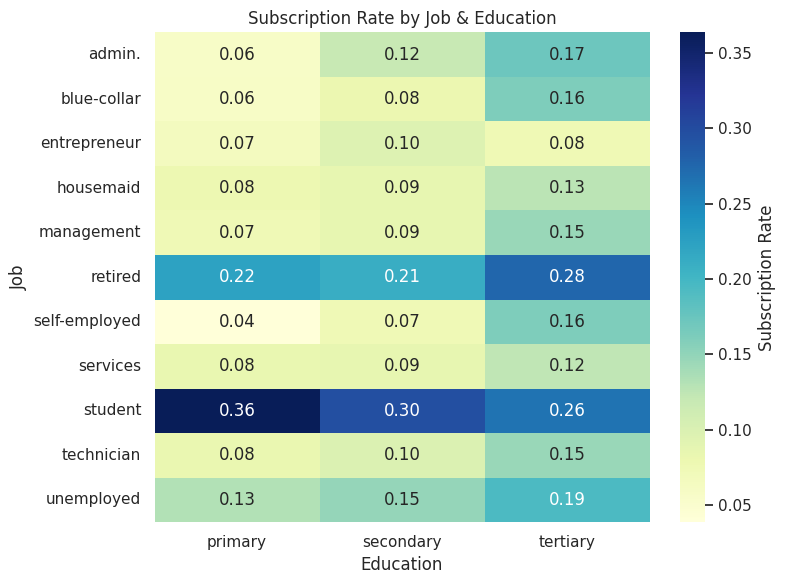

In [36]:
# Pivot table of subscription rate by job × education
pivot = data.pivot_table(
    index="job",
    columns="education",
    values="y",
    aggfunc="mean"
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar_kws={"label": "Subscription Rate"}
)
plt.title("Subscription Rate by Job & Education")
plt.xlabel("Education")
plt.ylabel("Job")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


<ipython-input-37-c564764f9d71>:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_jp = data.pivot_table(


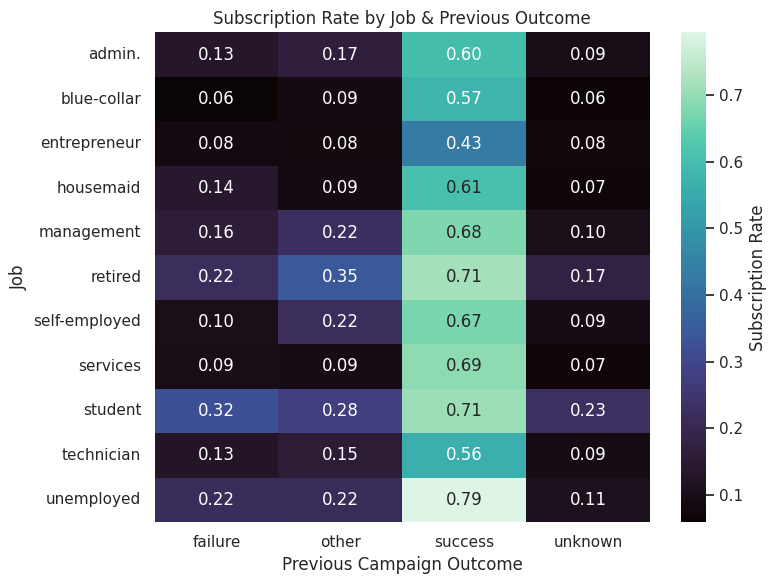

In [37]:
# Pivot table of subscription rate by job × previous outcome
pivot_jp = data.pivot_table(
    index="job",
    columns="poutcome",
    values="y",
    aggfunc="mean"
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    pivot_jp,
    annot=True,
    fmt=".2f",
    cmap="mako",
    cbar_kws={"label": "Subscription Rate"}
)
plt.title("Subscription Rate by Job & Previous Outcome")
plt.xlabel("Previous Campaign Outcome")
plt.ylabel("Job")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


<ipython-input-38-8e7e6becccf0>:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_pm = data.pivot_table(


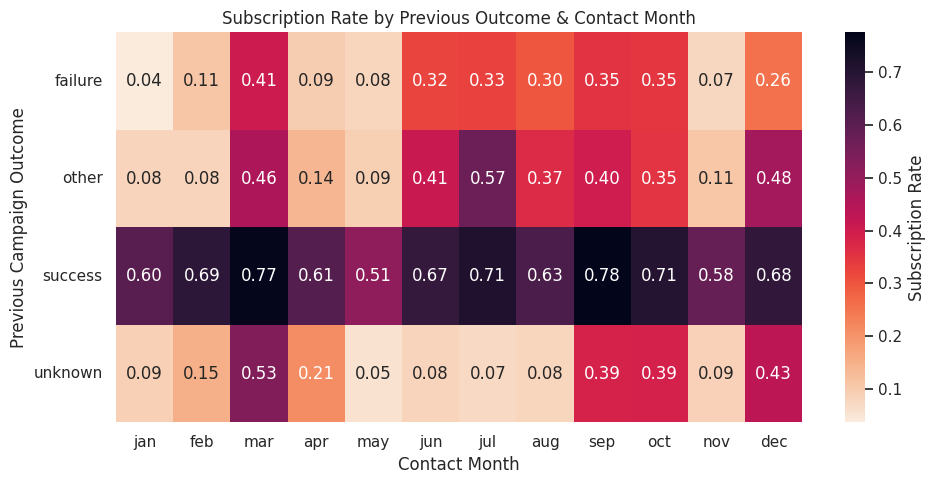

In [38]:
# Ensure your 'month' column is an ordered categorical with calendar order
month_order = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
data['month'] = pd.Categorical(data['month'], categories=month_order, ordered=True)

# Pivot table of subscription rate by previous outcome × contact month
pivot_pm = data.pivot_table(
    index='poutcome',
    columns='month',
    values='y',
    aggfunc='mean'
)

# Reindex the columns to calendar order
pivot_pm = pivot_pm[month_order]

# Plot
plt.figure(figsize=(10, 5))
sns.heatmap(
    pivot_pm,
    annot=True,
    fmt='.2f',
    cmap='rocket_r',
    cbar_kws={'label': 'Subscription Rate'}
)
plt.title('Subscription Rate by Previous Outcome & Contact Month')
plt.xlabel('Contact Month')
plt.ylabel('Previous Campaign Outcome')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


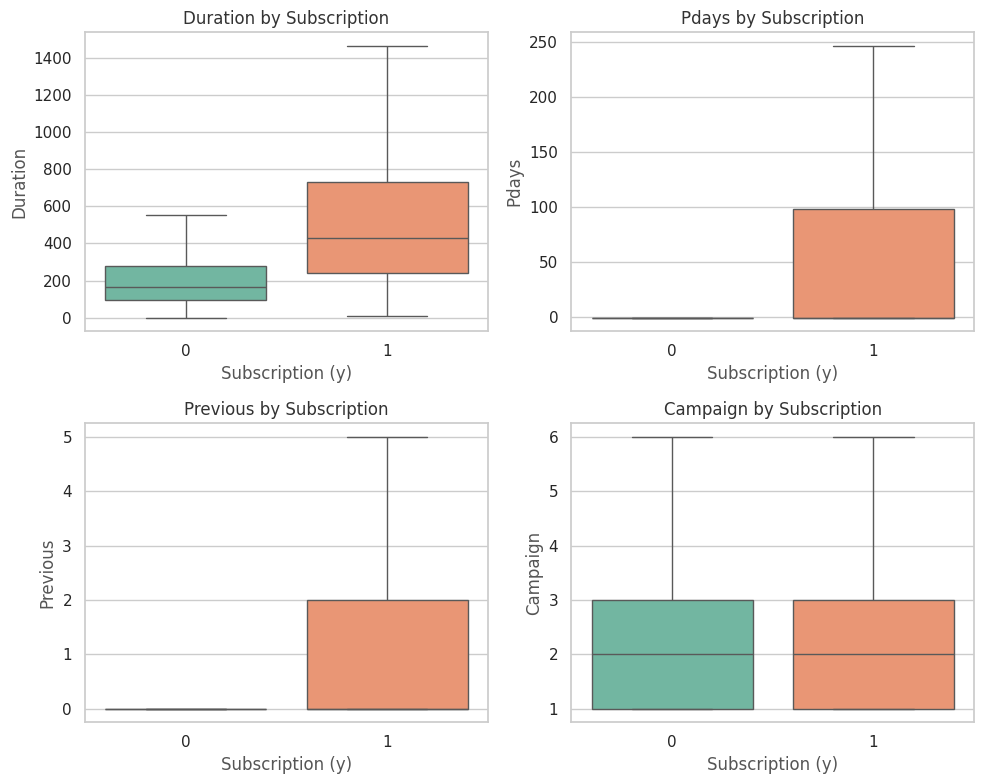

In [39]:
# Use a pastel palette with strong contrast
sns.set(style="whitegrid")

top_features = ['duration', 'pdays', 'previous', 'campaign']

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for ax, feat in zip(axes.flatten(), top_features):
    sns.boxplot(
        x='y',
        y=feat,
        hue='y',
        data=data,
        palette='Set2',
        dodge=False,
        showfliers=False,
        ax=ax
    )
    # Remove the separate legend entry for each subplot
    ax.legend_.remove()
    ax.set_title(f'{feat.capitalize()} by Subscription', color='#333')
    ax.set_xlabel('Subscription (y)', color='#555')
    ax.set_ylabel(feat.capitalize(), color='#555')

plt.tight_layout()
plt.show()


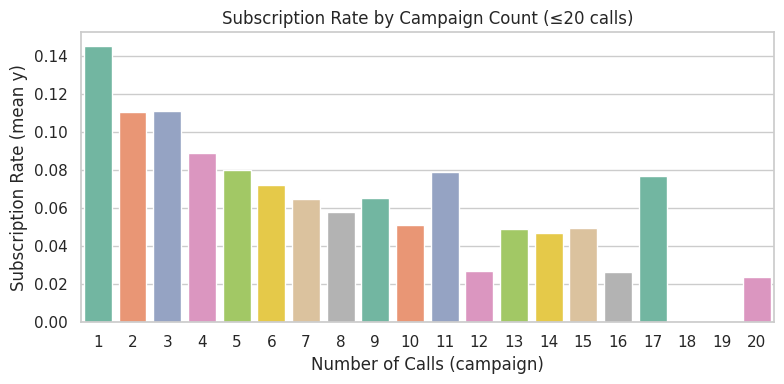

In [40]:
# Filter to campaign counts up to 20 calls
filtered = data[data['campaign'] <= 20]

# Compute subscription rate per number of calls
campaign_rate = (
    filtered.groupby('campaign')['y']
            .mean()
            .sort_index()
            .reset_index(name='rate')
)

plt.figure(figsize=(8,4))
sns.barplot(
    data=campaign_rate,
    x='campaign',
    y='rate',
    hue='campaign',
    palette='Set2',
    dodge=False,
    legend=False
)
plt.title('Subscription Rate by Campaign Count (≤20 calls)')
plt.xlabel('Number of Calls (campaign)')
plt.ylabel('Subscription Rate (mean y)')
plt.tight_layout()
plt.show()


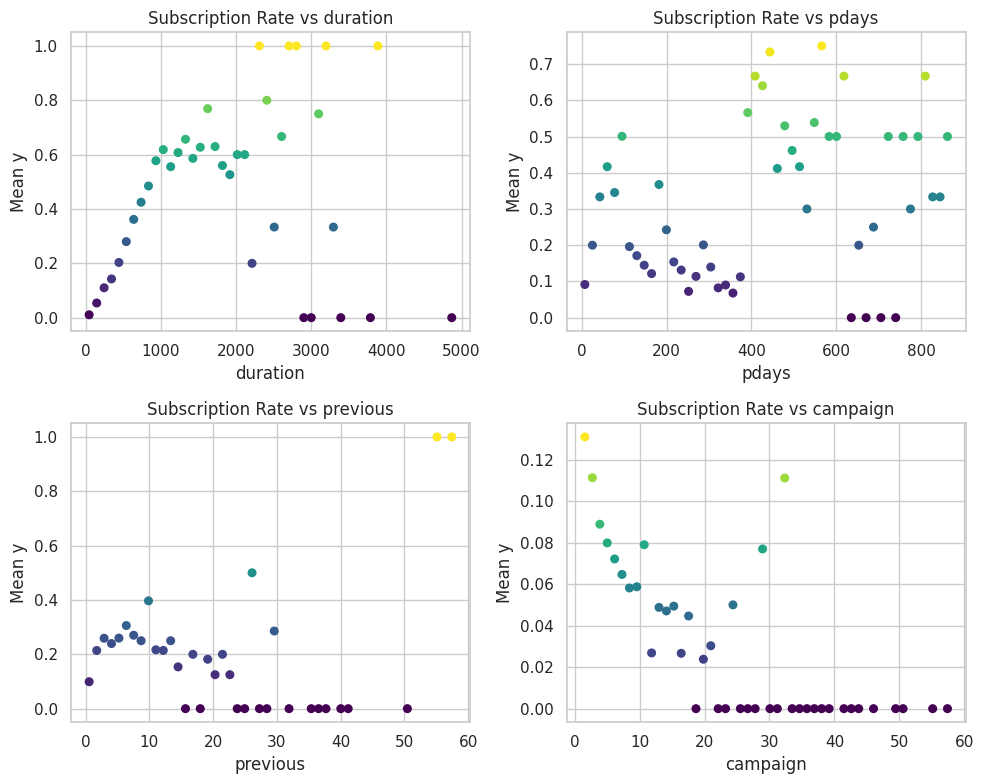

In [47]:
# filter out extreme 'previous' values
filtered = data[data['previous'] <= 100]

numeric_feats = ['duration', 'pdays', 'previous', 'campaign']
n_bins = 50

plt.figure(figsize=(10, 8))
for i, feat in enumerate(numeric_feats, 1):
    ax = plt.subplot(2, 2, i)
    # bin the feature into n_bins
    binned = pd.cut(filtered[feat], bins=n_bins)
    # compute subscription rate per bin, using observed=True
    rate_by_bin = filtered.groupby(binned, observed=True)['y'].mean()
    # get bin centers for plotting
    centers = [interval.mid for interval in rate_by_bin.index]
    ax.scatter(centers, rate_by_bin, c=rate_by_bin, cmap='viridis', s=30)
    ax.set_xlabel(feat)
    ax.set_ylabel('Mean y')
    ax.set_title(f'Subscription Rate vs {feat}')
plt.tight_layout()
plt.show()


In [43]:
### EDA – Key Insights



#### 1. Call Duration Dominates Numeric Predictors
# Correlation r ≈ 0.40
# Median call length for subscribers is roughly 2× that of non-subscribers.
# Success probability rises sharply up to ~1 500s and then levels off—an “S-curve” visible in both box-plots and binned-mean scatter.


#### 2. Previous-Campaign Outcome Is the Single Most Powerful Categorical Feature
# A prior success boosts conversion from the baseline 12% to 65% across almost every segment.
# Heat-map shows that this effect magnifies in March & September (up to 77%), while “unknown” outcome stays below 17 % year-round.



#### 3. Customer Segment Matters: Job × Education
# Within each job class, uptake climbs with education; e.g. retired-tertiary 28% vs retired-primary 22%.
# Top segments: students (≤ 35 %) and retirees (≈ 25%), even at lower education levels.
# Low segments: self-employed primary (≈ 4 %) and blue-collar generally (< 10 %).


#### 4. Call Intensity Shows Diminishing—and Sometimes Negative—Returns
# First call converts best (~14%); conversion declines monotonically to ~5% by the 10th call.
# A small rebound after 15 calls is due to few cases—risk of overfitting, so cap `campaign` at 10 and treat everything higher as “10+”.
# `pdays` and `previous` mirror this: moderate prior contact (5-15) helps, but excessive contact or very long gaps split into “all-yes” / “all-no” noise.

#### Summary for Modelling:
# Focus on `duration`, engineered `campaign`/`previous` caps, `poutcome` (and its interaction with month), and high-propensity segments defined by job & education. Address class imbalance with stratified split and class weights.
